In [1]:
# === 01 • Imports e carga do dataset ===
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# Caminho dos dados processados
DATA_PROCESSED = "../data/processed/listings_model_baseline.csv"

df = pd.read_csv(DATA_PROCESSED)
print(f"Shape inicial: {df.shape}")
df.head(3)


Shape inicial: (10743, 17)


,latitude,longitude,room_type,property_type,accommodates,bedrooms,bathrooms,beds,number_of_reviews,reviews_per_month,review_scores_rating,minimum_nights,maximum_nights,availability_365,instant_bookable,host_is_superhost,price
0,43.77709,11.25216,Private room,Private room in serviced apartment,2,1.0,1.0,1.0,156.0,0.85,4.67,1,99,345,1.0,NaN,130.0
1,43.76832,11.24348,Entire home/apt,Entire condo,4,2.0,2.0,3.0,40.0,0.22,4.77,6,31,162,0.0,0.0,112.0
2,43.76742,11.24378,Entire home/apt,Entire rental unit,4,2.0,1.0,2.0,34.0,0.19,4.48,4,1124,171,0.0,1.0,97.0


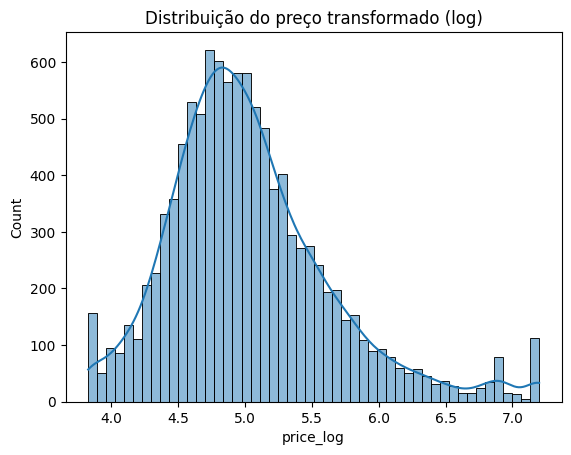

In [2]:
# === 02 • Transformação logarítmica do preço ===
df["price_log"] = np.log1p(df["price"])  # log(price+1)

sns.histplot(df["price_log"], bins=50, kde=True)
plt.title("Distribuição do preço transformado (log)")
plt.show()


In [3]:
# === 03 • Features numéricas e categóricas ===

TARGET = "price_log"

features_num = [
    "accommodates","bedrooms","bathrooms","beds",
    "number_of_reviews","reviews_per_month","review_scores_rating",
    "minimum_nights","maximum_nights","availability_365",
    "latitude","longitude"
]

features_cat = ["room_type","property_type"]

# One-hot encoding
df_encoded = pd.get_dummies(df[features_num + features_cat + [TARGET]], drop_first=True)

X = df_encoded.drop(columns=[TARGET])
y = df_encoded[TARGET]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [4]:
# === 04 • Função para avaliar modelos ===
def avaliar_modelo(nome, y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    print(f"=== {nome} ===")
    print(f"MAE : {mae:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"R²  : {r2:.2f}")
    return {"Modelo": nome, "MAE": mae, "RMSE": rmse, "R2": r2}


In [5]:
# === 05 • Treino Random Forest e XGBoost ===

# Random Forest
rf = RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)
res_rf = avaliar_modelo("Random Forest", y_test, rf_pred)

# XGBoost
xgb = XGBRegressor(
    n_estimators=500,
    learning_rate=0.1,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)
xgb.fit(X_train, y_train)
xgb_pred = xgb.predict(X_test)
res_xgb = avaliar_modelo("XGBoost", y_test, xgb_pred)


=== Random Forest ===
MAE : 0.29
RMSE: 0.43
R²  : 0.52
=== XGBoost ===
MAE : 0.29
RMSE: 0.42
R²  : 0.54


In [6]:
# === 06 • Comparação em tabela ===
import pandas as pd

resultados = pd.DataFrame([res_rf, res_xgb])
display(resultados)


,Modelo,MAE,RMSE,R2
0,Random Forest,0.293960,0.433113,0.516062
1,XGBoost,0.287305,0.421154,0.542418


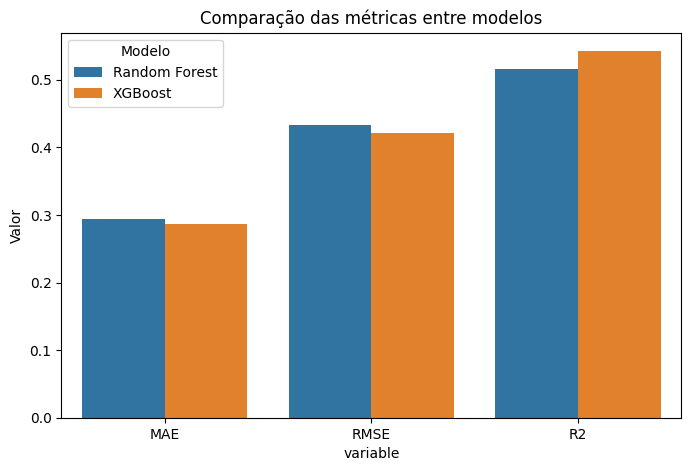

In [7]:
# === 07 • Visualização comparativa das métricas ===
plt.figure(figsize=(8,5))
sns.barplot(data=resultados.melt(id_vars="Modelo", value_vars=["MAE","RMSE","R2"]),
            x="variable", y="value", hue="Modelo")
plt.title("Comparação das métricas entre modelos")
plt.ylabel("Valor")
plt.show()


In [8]:
# === 08 • Eleição do melhor modelo ===
melhor = resultados.sort_values("RMSE").iloc[0]
print(f"O melhor modelo foi: {melhor['Modelo']} com RMSE={melhor['RMSE']:.2f} e R²={melhor['R2']:.2f}")


O melhor modelo foi: XGBoost com RMSE=0.42 e R²=0.54
